## DeepSaliency
https://github.com/zlmzju/DeepSaliency

In [1]:
#!/usr/bin/env python
import numpy as np
import sys
sys.path.insert(0,'/root/caffe/python')
import caffe
import cv2

def initNet(root_path='./model',device_no=0):
    MODEL_FILE = root_path+'/deploy.prototxt'
    PRETRAINED = root_path+'/train_iter_40000.caffemodel'
    if device_no>=0:
        caffe.set_device(device_no)
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()
    net = caffe.Classifier(MODEL_FILE, PRETRAINED,caffe.TEST)
    return net                       

#process only one image, one can modify it to process a batch of images
def processImage(net,filename):
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', np.array([ 104.00698793,  116.66876762,  122.67891434]))
    transformer.set_raw_scale('data', 255)  # images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # channels in BGR order instead of RGB

    img=caffe.io.load_image(filename)
    (H,W,C)=img.shape   #C=3

    #process the image
    imgData=transformer.preprocess('data',img)
    net.blobs['data'].data[...] = imgData
    net.forward()

    outmap=net.blobs['outmap'].data[0,0,:,:]
    map_final=cv2.resize(outmap,(W,H))
    map_final-=map_final.min()
    map_final/=map_final.max()
    map_final=np.ceil(map_final*255)
    return map_final, imgData

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


net=initNet('./model',0)

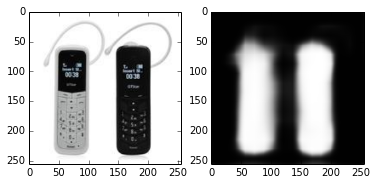

In [87]:
filename='/home/Salient-Object-Detection/data/cdiscount_selected/2891646_0.png'
salmap, imgData=processImage(net,filename)

plt.subplot(1,2,1);plt.imshow(caffe.io.load_image(filename))
plt.subplot(1,2,2);plt.imshow(salmap,cmap='gray')

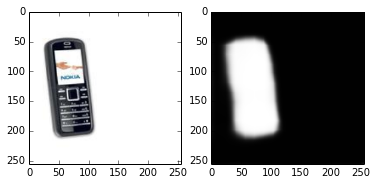

In [36]:
filename='/home/Salient-Object-Detection/data/cdiscount_selected/1250942_0.png'
salmap, imgData=processImage(net,filename)

plt.subplot(1,2,1);plt.imshow(caffe.io.load_image(filename))
plt.subplot(1,2,2);plt.imshow(salmap,cmap='gray')

In [ ]:
""" Functions for Converting Saliency Map to Bounding Boxes

    Example Usage:
        label_map = segment_from_grayscale( salmap, 100, 200 )
        bbox_lst = bbox_from_segment( label_map, 100 )

    Ref:
        http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html
        http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html
"""

from skimage.filters import sobel
from skimage.morphology import watershed

### 
def segment_from_grayscale( img, thres_low, thres_high ):
    # define markers
    markers = np.zeros_like(img)
    markers[salmap < thres_low] = 1
    markers[salmap > thres_high] = 2
    # get elevation map
    elevation_map = sobel(img/255)
    # find segmentation
    segmentation = watershed(elevation_map, markers)
    segmentation = ndi.binary_fill_holes(segmentation - 1)
    # label map
    label_map, _ = ndi.label(segmentation)
    return label_map

import matplotlib.patches as mpatches

def bbox_from_segment( label_map, min_area_sz ):
    bbox = []
    for region in measure.regionprops(label_map):
        # take regions with large enough areas
        if region.area >= min_area_sz:
            bbox.append( region.bbox )
    print bbox

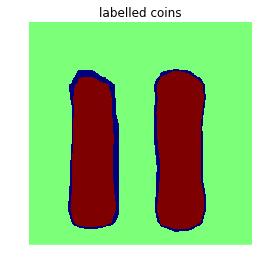

In [88]:
markers = np.zeros_like(salmap)
markers[salmap < 150] = 1
markers[salmap > 200] = 2
my_imshow(markers, 'labelled coins', cmap='jet')

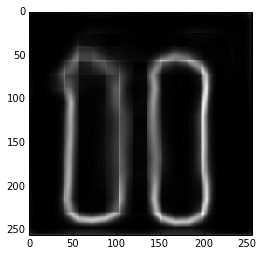

In [89]:
from skimage.filters import sobel
elevation_map = sobel(salmap/255)
plt.imshow(elevation_map, cmap='gray', interpolation='none')

In [90]:
from skimage.morphology import watershed
segmentation = watershed(elevation_map, markers)

In [91]:
segmentation = ndi.binary_fill_holes(segmentation - 1)

In [92]:
labeled_coins, _ = ndi.label(segmentation)

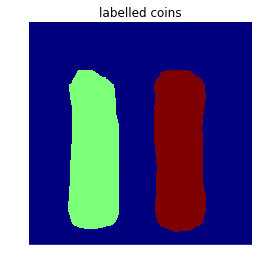

In [93]:
my_imshow(labeled_coins, 'labelled coins', cmap='jet')

In [98]:
import matplotlib.patches as mpatches

for region in measure.regionprops(labeled_coins):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        print (minr, minc)
        print (maxr, maxc)
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        print rect
    

(56L, 45L)
(238L, 104L)
Rectangle(45,56;59x182)
(56L, 144L)
(241L, 203L)
Rectangle(144,56;59x185)


In [5]:
def my_imshow(im, title=None, **kwargs):
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray'
    plt.figure()
    plt.imshow(im, interpolation='none', **kwargs)
    if title:
        plt.title(title)
    plt.axis('off')

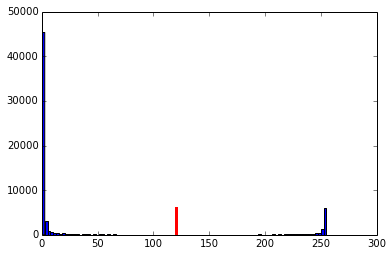

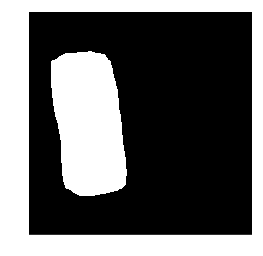

In [6]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(salmap)
thresholded = salmap > thresh

plt.figure()
plt.hist(salmap.ravel(), bins=100);
plt.plot([thresh, thresh], [0, 6000], linewidth=3, color='r');
plt.show()

my_imshow(thresholded)

(-0.5, 255.5, 255.5, -0.5)

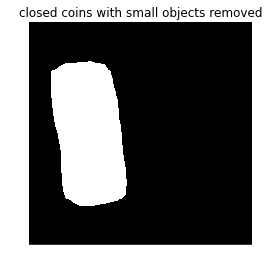

In [8]:
from skimage import morphology
from skimage.morphology import disk

no_small = morphology.remove_small_objects(thresholded, min_size=150)

coins = morphology.binary_closing(no_small,disk(3)) 
plt.figure()
plt.imshow(coins, cmap='gray', interpolation='none')
plt.title('closed coins with small objects removed')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

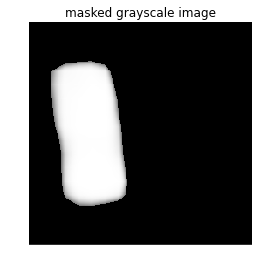

In [16]:
salmap[coins==False] = 0

plt.figure()
plt.imshow(salmap, cmap='gray', interpolation='none')
plt.title('masked grayscale image')
plt.axis('off')

In [19]:
from skimage.morphology import watershed
markers = np.zeros_like(coins)
markers[salmap < 30] = 1
markers[salmap > 150] = 2

segmentation = watershed(salmap, markers)

In [ ]:
segmentation = ndi.binary_fill_holes(segmentation - 1)
plt.imshow(segmentation, cmap='gray', interpolation='none')
labeled_coins, _ = ndi.label(segmentation)
print segmentation

In [24]:
print labeled_coins
print max(labeled_coins)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

distance transform: (256, 256) float64
number of coins: 9


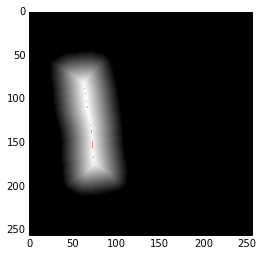

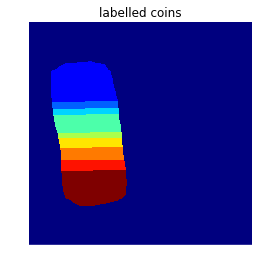

In [34]:
from scipy import ndimage as ndi
from matplotlib.colors import ListedColormap

distance_im = ndi.distance_transform_edt(coins)
print 'distance transform:', distance_im.shape, distance_im.dtype

from skimage import feature, measure

def imshow_overlay(im, mask, alpha=0.5, color='red', **kwargs):
    """Show semi-transparent red mask over an image"""
    mask = mask > 0
    mask = np.ma.masked_where(~mask, mask)        
    plt.imshow(im, **kwargs)
    plt.imshow(mask, alpha=alpha, cmap=ListedColormap([color]))


peaks_im = feature.peak_local_max(distance_im, indices=False, footprint=np.ones((9, 9)),
                            labels=coins)

plt.figure()
imshow_overlay(distance_im, peaks_im, alpha=0.5, cmap='gray')

markers_im = ndi.label(peaks_im)[0]
labelled_coins = morphology.watershed(-distance_im, markers_im, mask=coins) 
num_coins = len(np.unique(labelled_coins))-1  # subtract 1 b/c background is labelled 0
print 'number of coins: %i' % num_coins

my_imshow(labelled_coins, 'labelled coins', cmap='jet')

In [35]:
ll = 0
for y, rr in enumerate(peaks_im):
    for x, v in enumerate(rr):
        if v == True:
            ll = ll + 1
            print (x,y)
print ll

(63, 88)
(64, 94)
(65, 103)
(66, 109)
(66, 110)
(70, 130)
(71, 136)
(71, 137)
(71, 138)
(72, 149)
(72, 150)
(72, 151)
(72, 152)
(72, 153)
(72, 154)
(72, 155)
(72, 156)
(73, 166)
(73, 167)
(74, 173)
20


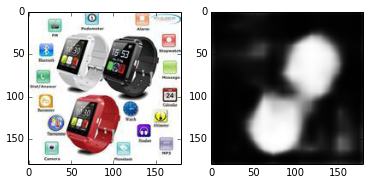

In [68]:
filename='/home/Salient-Object-Detection/data/cdiscount_selected/1581274_1.jpg'
salmap, imgData=processImage(net,filename)

plt.subplot(1,2,1);plt.imshow(caffe.io.load_image(filename))
plt.subplot(1,2,2);plt.imshow(salmap,cmap='gray')

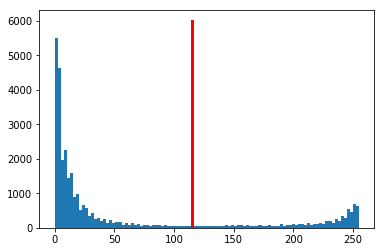

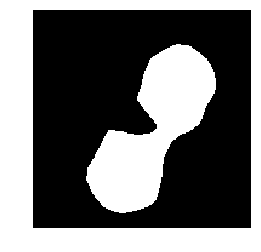

In [43]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(salmap)
thresholded = salmap > thresh

plt.figure()
plt.hist(salmap.ravel(), bins=100);
plt.plot([thresh, thresh], [0, 6000], linewidth=3, color='r');
plt.show()

my_imshow(thresholded)

/usr/local/lib/python2.7/dist-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


(-0.5, 179.5, 179.5, -0.5)

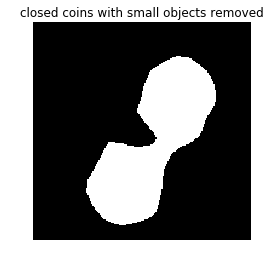

In [44]:
from skimage import morphology
from skimage.morphology import disk

no_small = morphology.remove_small_objects(thresholded, min_size=150)

coins = morphology.binary_closing(no_small,disk(3)) 
plt.figure()
plt.imshow(coins, cmap='gray', interpolation='none')
plt.title('closed coins with small objects removed')
plt.axis('off')

distance transform: (180, 180) float64
number of coins: 6


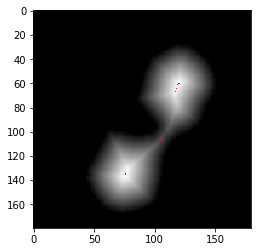

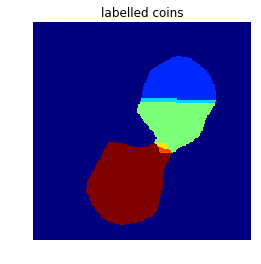

In [45]:
from scipy import ndimage as ndi
from matplotlib.colors import ListedColormap

distance_im = ndi.distance_transform_edt(coins)
print 'distance transform:', distance_im.shape, distance_im.dtype

from skimage import feature, measure

def imshow_overlay(im, mask, alpha=0.5, color='red', **kwargs):
    """Show semi-transparent red mask over an image"""
    mask = mask > 0
    mask = np.ma.masked_where(~mask, mask)        
    plt.imshow(im, **kwargs)
    plt.imshow(mask, alpha=alpha, cmap=ListedColormap([color]))


peaks_im = feature.peak_local_max(distance_im, indices=False)

plt.figure()
imshow_overlay(distance_im, peaks_im, alpha=1, cmap='gray')

markers_im = measure.label(peaks_im)
labelled_coins = morphology.watershed(-distance_im, markers_im, mask=coins) 
num_coins = len(np.unique(labelled_coins))-1  # subtract 1 b/c background is labelled 0
print 'number of coins: %i' % num_coins

my_imshow(labelled_coins, 'labelled coins', cmap='jet')

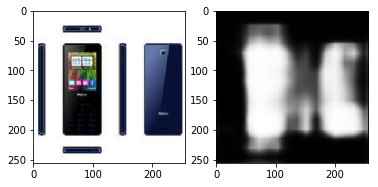

In [46]:
filename='./images/2329286_1.png'
salmap, imgData=processImage(net,filename)

mapname='./images/output.png'
cv2.imwrite(mapname,salmap)

plt.subplot(1,2,1);plt.imshow(caffe.io.load_image(filename))
plt.subplot(1,2,2);plt.imshow(salmap,cmap='gray')

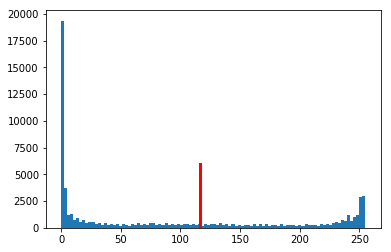

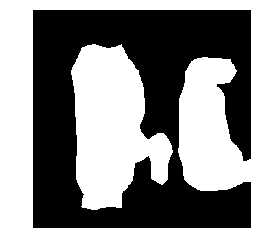

In [47]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(salmap)
thresholded = salmap > thresh

plt.figure()
plt.hist(salmap.ravel(), bins=100);
plt.plot([thresh, thresh], [0, 6000], linewidth=3, color='r');
plt.show()

my_imshow(thresholded)

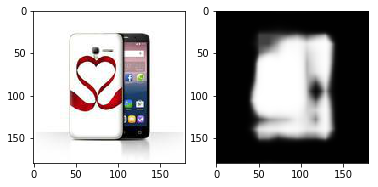

In [48]:
filename='./images/52547_0.jpg'
salmap, imgData=processImage(net,filename)

mapname='./images/output.png'
cv2.imwrite(mapname,salmap)

plt.subplot(1,2,1);plt.imshow(caffe.io.load_image(filename))
plt.subplot(1,2,2);plt.imshow(salmap,cmap='gray')

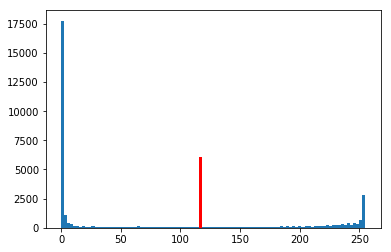

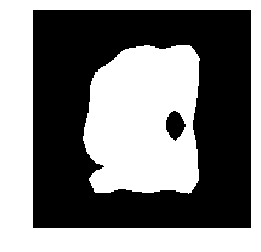

In [49]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(salmap)
thresholded = salmap > thresh

plt.figure()
plt.hist(salmap.ravel(), bins=100);
plt.plot([thresh, thresh], [0, 6000], linewidth=3, color='r');
plt.show()

my_imshow(thresholded)

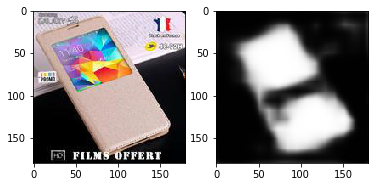

In [50]:
filename='./images/88015_0.jpg'
salmap, imgData=processImage(net,filename)

mapname='./images/output.png'
cv2.imwrite(mapname,salmap)

plt.subplot(1,2,1);plt.imshow(caffe.io.load_image(filename))
plt.subplot(1,2,2);plt.imshow(salmap,cmap='gray')

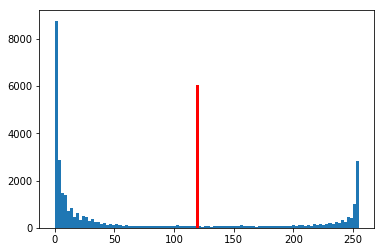

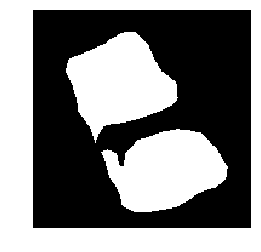

In [51]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(salmap)
thresholded = salmap > thresh

plt.figure()
plt.hist(salmap.ravel(), bins=100);
plt.plot([thresh, thresh], [0, 6000], linewidth=3, color='r');
plt.show()

my_imshow(thresholded)

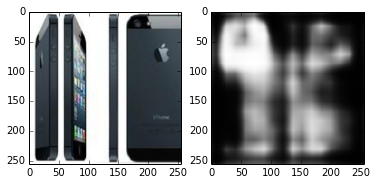

In [22]:
filename='./images/2738078_3.png'
salmap, imgData=processImage(net,filename)

mapname='./images/output.png'
cv2.imwrite(mapname,salmap)

plt.subplot(1,2,1);plt.imshow(caffe.io.load_image(filename))
plt.subplot(1,2,2);plt.imshow(salmap,cmap='gray')

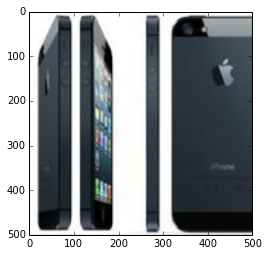

In [29]:
### check if the enlarged 500x500 image looks okay 
_imgData = np.transpose(imgData,(1,2,0)) # change CxHxW back to WxHxC
_imgData = _imgData + np.array([ 104.00698793,  116.66876762,  122.67891434]) # add back shifted mean
_imgData = _imgData[...,[2,1,0]]/255 # BGR to RGB + scaling
plt.imshow( _imgData )